In [13]:
from utils_NXP_N7 import *  # noqa: F403,F401
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
from tensorflow.keras import layers, Sequential

def create_model_CNN(input_shape, num_classes):

    model = Sequential(name = "CNN_Model")

    # Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Bloc 1 
    model.add(layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding='same',
        activation='relu',
        input_shape=(3286,2)
    ))
    model.add(layers.BatchNormalization())

    model.add(layers.AveragePooling1D(pool_size=2))

    # Dropout 
    model.add(layers.Dropout(0.5))

    #Bloc 2
    model.add(layers.Conv1D(
        filters=8,
        kernel_size=5,
        padding='same',
        activation='relu',
    ))
    model.add(layers.BatchNormalization())

    # #Bloc 3
    # model.add(layers.Conv1D(
    #     filters=128,
    #     kernel_size=3,
    #     padding='same',
    #     activation='relu',  
    # ))
    # model.add(layers.BatchNormalization())


    # Dropout 
    model.add(layers.Dropout(0.5))

    model.add(layers.AveragePooling1D(pool_size=2))



    model.add(layers.Flatten())

    model.add(layers.Dense(16, activation='relu'))

    model.add(layers.Dense(num_classes))

    # Couche de sortie : LOGITS, sans softmax
    #model.add(layers.Dense(num_classes, activation=None, name="relu"))

    # Output Layer
    # model.add(layers.Dense(num_classes, activation='softmax')) #softmax pas supporté par la carte
    model.add(layers.Activation('softmax'))
    


    return model
    

print("Model definition complete at 100%.")

Model definition complete at 100%.


In [26]:
#from model_definition import create_model_CNN
# Charger les données
X_train, X_test, y_train, y_test = load_data(
    "data_processed/data_processeddata_df.csv",
    "data_processed/data_processedlabels_df.csv"
)

VAL_RATIO = 0.2  # Pourcentage de données à utiliser pour la validation
percent = int(X_train.shape[0] * (1 - VAL_RATIO))
X_val, y_val = X_train[percent:], y_train[percent:]
X_train, y_train = X_train[:percent], y_train[:percent]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

# Préparer les datasets TensorFlow
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.batch(32, drop_remainder=True)

# Préparer les datasets TensorFlow
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.batch(32, drop_remainder=True)



In [27]:
# Définir les paramètres du modèle
input_shape = X_train.shape[1:] # Forme des données d'entrée
num_classes = 10 #len(np.unique(y_train))  # Nombre de classes pour la classification
model = create_model_CNN(input_shape, num_classes)
model.summary()

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 3286, 16)       │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3286, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 1643, 16)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1643, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1643, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1643, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1643, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 821, 8)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │       105,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,130 (414.57 KB)

 Trainable params: 106,082 (414.38 KB)

 Non-trainable params: 48 (192.00 B)

In [41]:
train

<_BatchDataset element_spec=(TensorSpec(shape=(32, 3286, 2), dtype=tf.int16, name=None), TensorSpec(shape=(32, 10), dtype=tf.float64, name=None))>

In [29]:

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
# Définir les callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,            
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
]

In [31]:
# Entraîner le modèle
history = model.fit(
    train, validation_data=val,
    epochs=300,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2143 - loss: 2.1150 - val_accuracy: 0.2083 - val_loss: 2.5703 - learning_rate: 0.0010
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3594 - loss: 1.6573 - val_accuracy: 0.2812 - val_loss: 2.6840 - learning_rate: 0.0010
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5201 - loss: 1.4121 - val_accuracy: 0.3958 - val_loss: 2.4380 - learning_rate: 0.0010
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5179 - loss: 1.2984 - val_accuracy: 0.3958 - val_loss: 2.3757 - learning_rate: 0.0010
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5871 - loss: 1.0937 - val_accuracy: 0.5521 - val_loss: 1.7966 - learning_rate: 0.0010
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6696 - loss: 0.9399 - val_accuracy: 0.5833 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7098 - loss: 0.7787 - 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8438 - loss: 1.1827

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8750 - loss: 0.7039
Test Loss: 0.7039476037025452, Test Accuracy: 0.875
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Matrice de confusion :
 [[14  0  0  0  0  0  2  0  0  0]
 [ 0  9  0  0  0  0  1  1  0  0]
 [ 0  0 14  0  0  0  0  0  1  0]
 [ 0  0  0 17  0  0  0  0  0  0]
 [ 0  1  0  0 14  0  0  0  0  1]
 [ 0  0  1  1  1  8  2  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  1  0 21  0]
 [ 0  1  0  0  0  1  0  0  0  9]]

Precision : 0.9090655041359267
Recall    : 0.8943661971830986
F1-score  : 0.8952045716243807


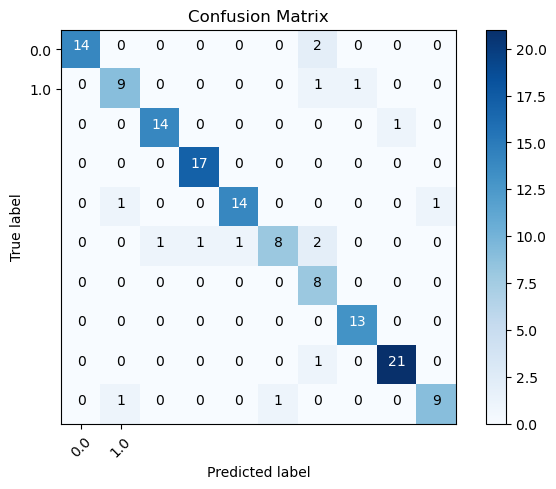

In [32]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(val)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


# # Matrice de confusion
# y_pred = np.argmax(model.predict(X_test), axis=-1)
# cm = tf.math.confusion_matrix(y_test, y_pred, num_classes = 10)

# cm = cm.numpy()

# Prédictions + matrice de confusion
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)

cm = tf.math.confusion_matrix(y_test, y_pred)
class_names = [str(c) for c in np.unique(y_train)]
cm = cm.numpy() 
print("\nMatrice de confusion :\n", cm)
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")


# Calcul des métriques : précision, rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print(f"\nPrecision : {precision}")
print(f"Recall    : {recall}")
print(f"F1-score  : {f1}")

In [33]:
# Suppresion de la derniere couche pour compatibilité NXP
model_trunc = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [10]:
model_trunc.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3284, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3284, 16)       │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3284, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 1642, 16)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1642, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1642, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1642, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1642, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 821, 8)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        65,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,546 (259.95 KB)

 Trainable params: 66,498 (259.76 KB)

 Non-trainable params: 48 (192.00 B)

In [34]:
# Sauvegarde du modèle complet
model.save("./model/model_saved.keras")
print("model saved.")


# Sauvegarde du modèle tronqué
model_trunc.save("./model/model_trunc_saved.keras")
# print("model_trunc saved.")

model saved.


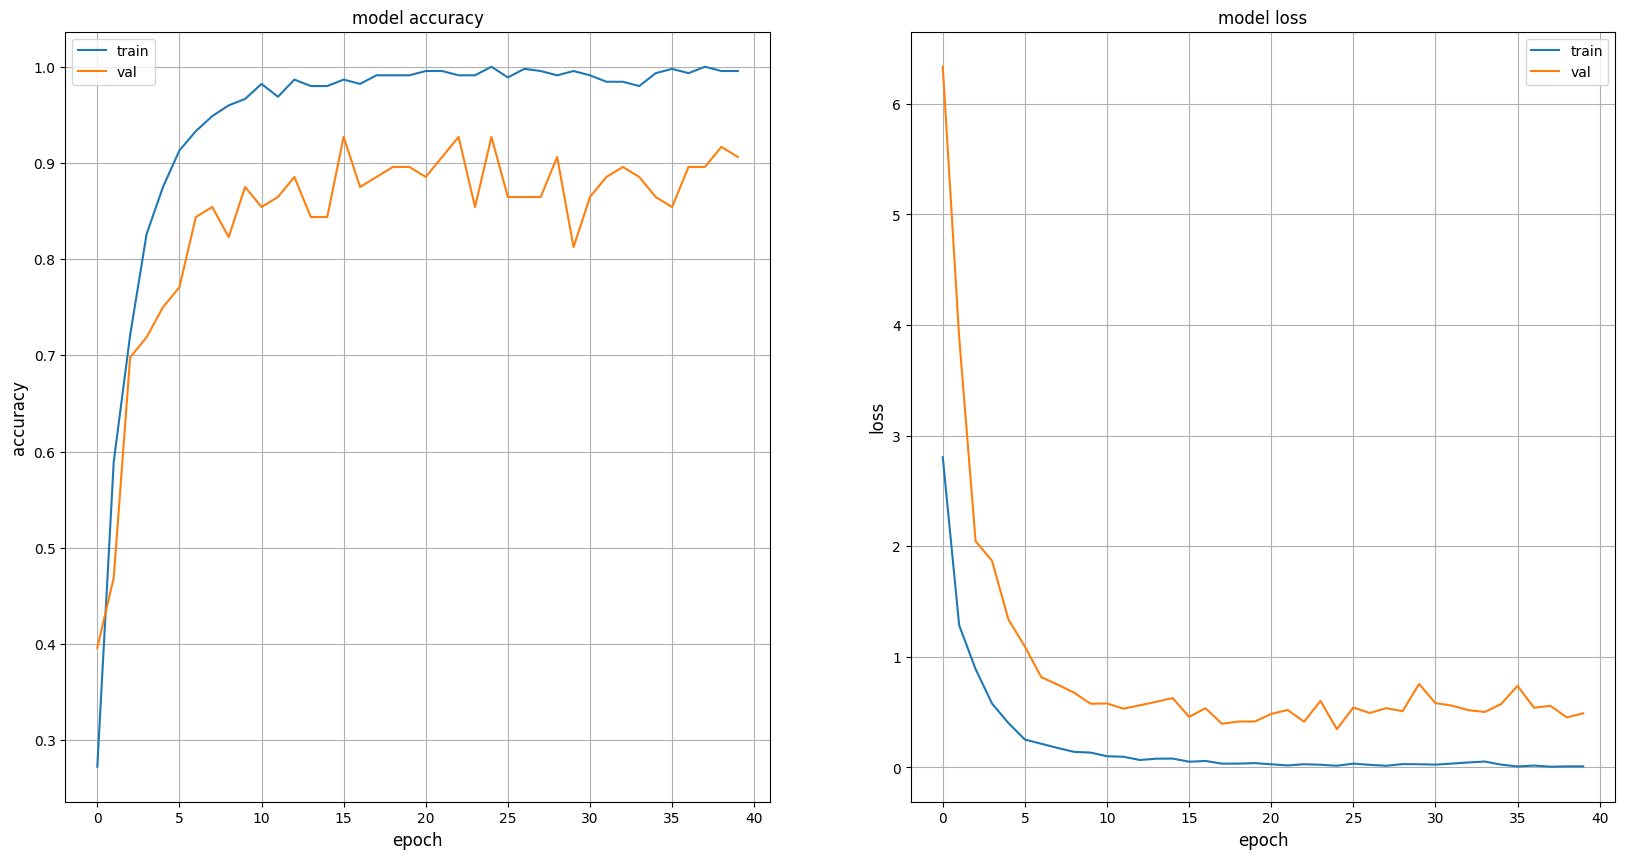

In [10]:
plot_scores(history)  # Plot validation accuracy

In [ ]:
y_pred_full  = np.argmax(model.predict(X_test), axis=1)
y_pred_trunc = np.argmax(model_trunc.predict(X_test), axis=1)

# Vérifier combien de prédictions diffèrent
diff = np.mean(y_pred_full != y_pred_trunc)
print("Taux de prédictions différentes :", diff)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Taux de prédictions différentes : 0.8943661971830986


In [35]:
# Model quantization

# Representative dataset generator
def representative_data_gen():
    for i in range(50): #X_test[:50]
        yield [X_train[i:i+1].astype(np.float32)]

# Créer le convertisseur TFLite à partir du modèle Keras sauvegardé
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model_trunc)
# Configurer la quantization int8 complète
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Sauvegarder le modèle quantifié
with open("./model/tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)
print("Quantized model saved as tflite_quant_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmpmm21feyr\assets


INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmpmm21feyr\assets


Saved artifact at 'C:\Users\BILAAA~1\AppData\Local\Temp\tmpmm21feyr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3286, 2), dtype=tf.float32, name='keras_tensor_67')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1914775510656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914911744496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914911749424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914911751184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914911747664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914911749952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914940455600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914940453840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914940506704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1914940509696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model saved as tflite_quant_model.tflite


In [36]:
# TensorFlow Lite Interpreter Setup
tflite_interpreter = tf.lite.Interpreter(model_path="./model/tflite_quant_model.tflite")
tflite_interpreter.allocate_tensors()

# Insepect input and output details
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

# Quantization Parameters: Zero point and scale 
zero_point_input = input_details[0]['quantization_parameters']['zero_points'][0]
scale_input = input_details[0]['quantization_parameters']['scales'][0]

# Quantizing the test data
X_test_8 = np.round(X_test.astype(np.float32) / scale_input + zero_point_input).astype(np.int8)

# Running Inference with the Quantized model
output_array = np.zeros((X_test.shape[0], 10))
for i in range(X_test.shape[0]):
    X = np.reshape(X_test_8[i], (1, X_test_8.shape[1], X_test_8.shape[2]))
    tflite_interpreter.set_tensor(input_details[0]['index'], X)
    tflite_interpreter.invoke()
    output_array[i] = tflite_interpreter.get_tensor(output_details[0]['index'])


output_details = tflite_interpreter.get_output_details()

zero_point_output = output_details[0]['quantization_parameters']['zero_points'][0]
scale_output      = output_details[0]['quantization_parameters']['scales'][0]

# Dequantizing the Output
y_pred_tflite = (output_array - zero_point_output) * scale_output
y_pred_tflite = np.argmax(y_pred_tflite, axis=1)



c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


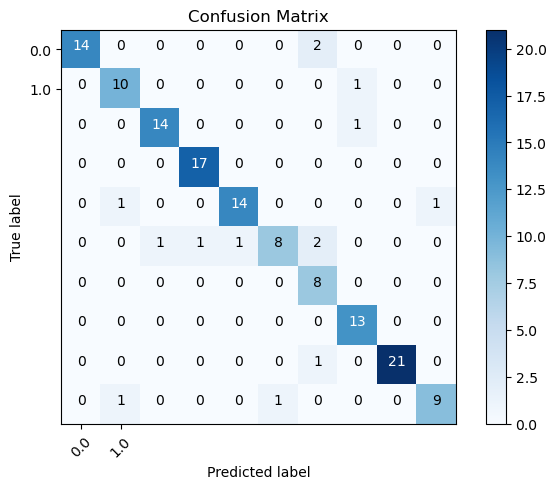

In [37]:
# Matrice de confusion pour le modèle quantifié
cm = tf.math.confusion_matrix(y_test, y_pred_tflite)
class_names = [str(c) for c in np.unique(y_train)]
cm = cm.numpy() 

plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")

In [27]:
# Sauvegarde du modèle quantifié
with open("./model/tf_model_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)
print("Quantized model saved as tf_model_int8.tflite")

Quantized model saved as tf_model_int8.tflite


In [78]:
import tensorflow as tf
import numpy as np

def representative_data_gen():
    for i in range(100):
        data = X_train[i:i+1].astype("float32")
        yield [data]


converter = tf.lite.TFLiteConverter.from_keras_model(model_trunc)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_int8_2 = converter.convert()

output_file = "model_int8_2.tflite"
with open(output_file, "wb") as f:
    f.write(tflite_model_int8_2)

print("Saved INT8 quantized model to:",output_file)

INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmprvi729gg\assets


INFO:tensorflow:Assets written to: C:\Users\BILAAA~1\AppData\Local\Temp\tmprvi729gg\assets


Saved artifact at 'C:\Users\BILAAA~1\AppData\Local\Temp\tmprvi729gg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3286, 2), dtype=tf.float32, name='keras_tensor_201')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2464899747856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464899744688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464902369648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464902365776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464902365600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464902368944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464898498976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464898141168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464898215680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2464898210048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

c:\Users\bilaaaaaaal\anaconda3\envs\conda-tf\lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved INT8 quantized model to: model_int8_2.tflite
